We seek to accomplish four things here in our analysis of the term structure of treasury notes:  
1) Interpolate yields between maturities on a daily basis  
2) Run a regression on interpolated values to determine a linear slope (look at the coefficients) throughout the yield curve  
3) Measure the change in both the slope (any timeline or stat - like mean yield for the week) and the levels of rates by maturity, to discover steepening/flattening and increase/decrease of yields      
4) For context of moves in the yield curves, will plot the distribution of weekly changes in levels and differences in yields between differing maturities (2-10, 10-30)... running this analysis on both a linear scale and natural log

For background information: Fed's methodology for [calculating](http://www.treasury.gov/resource-center/data-chart-center/interest-rates/Pages/yieldmethod.aspx) yield curve. More information on methodology may be found [here](http://www.treasury.gov/resource-center/data-chart-center/interest-rates/Pages/TextView.aspx?data=yield). The yields provided by FRED are constant maturity and may involve interpolation/bootstrapping between the latest on the run and off the run bonds. Thus, prices for any given maturity may not be readily observable.

In [1]:
from fredapi import Fred
import pandas as pd
import numpy as np
import math as math
import matplotlib.pyplot as plt
%matplotlib inline
fred= Fred(api_key='70da3ebf45f3904117b34c5147b93443')

In [2]:
tres10=fred.get_series('DGS10',observation_start='2015-01-01')
tedrate=fred.get_series('TEDRATE',observation_start='2015-01-01')
twoyr=fred.get_series('DGS2',observation_start='2015-01-01')
thirty=fred.get_series('DGS30',observation_start='2015-01-01')
five=fred.get_series('DGS5',observation_start='2015-01-01')

oneyr=fred.get_series('DGS1', observation_start='2015-01-01')
twentyyr=fred.get_series('DGS20',observation_start='2015-01-01')
threemon=fred.get_series('DGS3MO',observation_start='2015-01-01')
threeyr=fred.get_series('DGS3',observation_start='2015-01-01')
sevenyr=fred.get_series('DGS7',observation_start='2015-01-01')
sixmon=fred.get_series('DGS6MO',observation_start='2015-01-01')

Put all four treasury series in a data frame:

In [ ]:
dic={'ten':tres10,'twoyr':twoyr,'five':five,'thirty':thirty,'one':oneyr,'twenty':twentyyr,'three_month':threemon,'three':threeyr,'seven':sevenyr,'six_month':sixmon}
dic_df=pd.DataFrame(dic)

In [ ]:
dic_df.columns

In [ ]:
#organizing the df by maturity
df=dic_df.iloc[:,[7,3,1,9,6,0,2,4,8,5]]
#print 'length of dic_df: ', dic_df.shape
#print list(dic_df.index)[4]
df.tail()

#real=np.array(df.iloc[4,])
#len(real)

In [ ]:
from scipy.stats import itemfreq #a function that counts frequency of variables
#this function does the same: np.unique(removed, return_counts=True)

In [ ]:
removed=df.apply(pd.notnull,axis=1,reduce=True)
removed_1=removed.any(axis=1)

free=df[removed_1]

Applying a linear interpolation:

In [ ]:
import scipy.interpolate as sp
x=np.array([.25,.5,1,2,3,5,7,10,20,30])
real=np.array(free.iloc[215,]) #grab one particular day of observed yields
#interp1d = derive a function f(x)
test=sp.interp1d(x,real,kind='linear') #notice that this is 1-d interpolation
xnew=np.linspace(.5,30,num=41,endpoint=True) #linspace returns evenly spaced numbers over a specified interval
plt.plot(x, real, 'o', xnew, test(xnew), '-')
noGood=list(free.index)[215].strftime("%B %d %Y") #free = name of dataframe
ttl=plt.title(noGood)


plt.show()

Let's try it again, this time with a quadratic approximation... however, I think fitting a quadratic model is a more appropriate way to state it... one cannot apply linear or quadratic approximation w/o having the function. Linear and quadratic interpolation derive the function.

In [ ]:
xnew=np.linspace(.25,30,num=41,endpoint=True)
print(xnew)

In [ ]:
x=np.array([.25,.5,1,2,3,5,7,10,20,30])
real=np.array(free.iloc[208,])
#interp1d = derive a function f(x)
quad=sp.interp1d(x,real,kind='quadratic') #notice that this is 1-d interpolation
xnew=np.linspace(2,30,num=41,endpoint=True)

plt.plot(x, real, 'o', xnew, quad(xnew), '-')

#try to place both graphs in a row array
#fig, axs = plt.subplots(1, 2, sharey=True)

plt.show()

We try to determine steepening of the curve as well as steepness within a maturity range - short, mid and long dated. The slope will allow for comparison to other points in time... we still search for the most appropriate method to determine slope.

Below, we take the natural logarithm (inverse exponential function) of the yield to maturities.

In [ ]:
import math
print(free.iloc[208,])
print(free.iloc[208,].map(math.log))

logged=free.iloc[208,].map(math.log)

In [ ]:
import scipy.interpolate as sp
x=np.array([.25,.5,1,2,3,5,7,10,20,30]) #length = 10
real=np.array(logged)
#interp1d = derive a function f(x)
test=sp.interp1d(x,real,kind='linear') #notice that this is 1-d interpolation
xnew=np.linspace(.5,30,num=41,endpoint=True) #linspace returns evenly spaced numbers over a specified interval
plt.plot(x, real, 'o', xnew, test(xnew), '-')
noGood='Logged yield observations - ' + list(free.index)[215].strftime("%B %d %Y")
ttl=plt.title(noGood)

plt.show()

We didn't get much from applying the natural log... although it may help with future regressions. This may make application of linear regression to portions of the curve a bit more feasible... notice how the short end and long end yields are nearly flat.

Last resort... apply a spline function to the data points. We should only need to take the spline to the order of two or one (quadratic or linear). Some background on a [spline function](http://www.psych.mcgill.ca/misc/fda/ex-basis-c3.html), and [here](https://en.wikibooks.org/wiki/Introduction_to_Numerical_Methods/Interpolation). Interpreting [coefficients](http://www.cs.mtu.edu/~shene/COURSES/cs3621/NOTES/spline/B-spline/bspline-basis.html), more [here](http://stats.stackexchange.com/questions/97845/interpreting-spline-results), and [here](http://www.r-bloggers.com/splines-opening-the-black-box/).

I'm not sure the order size of the below. I will ultimately need to extract the derivative to determine slope.

There are many spline functions/utilities that can be applied here depending on number of dimensions and how I want to control the knot points. A smoothing spline will use fewer data points. My space is a one-dimensional where I want to force the spline through each data point, and so desire no smoothing.

Below is a univariate spline, a 1-d spline with parameters for smoothing. Here we apply no smoothing, thus forcing the spline through each of the data points. This function implicitly executes 'splprep'.

In [ ]:
#Pick a day to run the interpolation - we choose day 216

#free.columns.values
#free.shape
y=free.iloc[216,]
# 's' becomes a function that takes an independent variable as a parameter
s=sp.InterpolatedUnivariateSpline(x,y) #sp = scipy.interpolate... x = term to maturity (fraction of yrs, the 'x' points of real data); y = yield
xnew=np.arange(0,max(x),max(x)/40) #intermittent x points
ynew=s(xnew) # 's' becomes a function to which we apply the new x coordinates

In [ ]:
plt.figure()
plt.plot(x, y, 'x', xnew, ynew, '-')
#plt.plot(x, y, 'x', xnew, ynew, xnew, np.sin(xnew), x, y, 'b')
plt.legend(['Linear', 'InterpolatedUnivariateSpline', 'True'],loc=2)
#plt.axis(x)
plt.title('InterpolatedUnivariateSpline')
plt.show()

Let's extract the derivative of the spline function and plot it... we want to compare this spline with the explicit cubic spline we calculate below.

Problem: interpolatedunivariatespline derivative function is only available at specific values of x, and returns a family of derivatives (0th, 1st, 2nd, etc). And the command "ynew_univ_der = sp.splev(xnew, s, der=1) #tck = sp.splrep(x, y, s=0)" doesn't work because 's' is not iterable.

Fitting a spline based on the generic splprep function.

In [ ]:
tck = sp.splrep(x, y, s=0) #s for smoothing= control the trade-off between closeness and smoothness of fit. Larger s means more smoothing while smaller values of s indicate less smoothing
#tck = a tuple containing the vector of knots, the B-spline coefficients, and the degree of the spline
xnew = np.arange(0,max(x),max(x)/40)
ynew_splprep = sp.splev(xnew, tck, der=0)

In [ ]:
print ("x = {0}".format(x))
print"tck output: vector of knots= {0}; B-spline coefficients= {1}; degree of the spline={2}".format(tck[0],tck[1],tck[2])

In [ ]:
plt.figure()
plt.plot(x, y, 'x', xnew, ynew_splprep, '-')
plt.legend(['Actual', 'Cubic Spline', 'True'])

plt.title('Cubic-spline interpolation')
plt.show()


Derive the derivative of the chosen spline and attempt to glean the gradient of the slope... can perhaps use the derivative function to compare changes in yield curve.

In [ ]:
ynew_der = sp.splev(xnew, tck, der=1) #tck = sp.splrep(x, y, s=0)
plt.figure()
testies=np.repeat(0,len(xnew))
plt.plot(xnew, ynew_splprep, '-',xnew,ynew_der,'--',xnew,testies,'-')
plt.legend(['Cubic Spline', 'Derivative'])
plt.axis([-0.05, 30.5, -1.05, 4.5]) #a matrix of x, y vectors that frame the graph
plt.title('Derivative estimation from spline')
#ax1.axhline(y=0.000,xmin=0,xmax=3,c="blue",linewidth=0.5,zorder=0)
plt.show()

The above plot of the derivative looks too flat for the observed slope of the cubic spline. Let's try to get some raw data on the cubic spline and calculate discrete slopes.

In [ ]:
rate_series=pd.Series(sp.splev(xnew, tck, der=0),index=xnew) #let's put this into a time series w/index= maturity

In [ ]:
def slope(ser):
    rates={} #create dictionary
    for i in range(len(ser)-1):
        rates[ser.index[i]]=(ser.iloc[i+1]-ser.iloc[i])/(ser.index[i+1]-ser.index[i])
    return rates
slopers=slope(rate_series)

OK, well, the derivative function looks legit when compared with the discrete slopes...

Above is the plot of the derivative. We now want to track the value of derivative for different ranges of x - used to capture the change in slope over different ranges of maturity - short, medium, long.

It appears that calculating (change in y)/(change in x) from the linear interpolation may be good enough... because derivatives are only useful for examining changes in yield to very small ranges of x*, but I want a wider scope of term to maturities.

Spline interpolation is useful if I want to solve the derivative for a specified value (or range) of x that is not provided by the FRED data. This tract involves measuring the vertical distance in the derivative functions for different days.

*Not correct: we can integrate over the height of the yield curve to arrive at the area underneath the curve to understand levels of the curve. We apply this again to understand changes in slope: the slope of the yield curve is the first derivative to the untreated yield curve function. We will integrate through this derivate to arrive at the area under the derivative function and compare this to other trading days to understand changes in slope. We treat slope as an integrable function because the slope changes rapidly across the yield curve.


We'll try that here: measure the vertical distance across the entire range of x and pinpoint ranges of x where there is a vertical difference. We run this analysis on the real x-points from the FRED data. We can try this later on the spline curve. We will compare row free.iloc[243] (day 243) to free.iloc[230] (day 230).

In [ ]:
day243=free.iloc[243]
day230=free.iloc[230]

tck243 = sp.splrep(x, day243, s=0)
tck230 = sp.splrep(x, day230, s=0)

xnew = np.arange(0,max(x),max(x)/40)
ynew_splprep = sp.splev(xnew, tck243, der=0)
ynew_splprep = sp.splev(xnew, tck230, der=0)

Measuring differences between the real x-values as opposed to the spline interpolated values.

In [ ]:
diff13=day243-day230
print ("Linear difference between two days: \n{0}".format(diff13))
#print"tck output: vector of knots= {0}; B-spline coefficients= {1}; degree of the spline={2}".format(tck[0],tck[1],tck[2])

#day243-day230

In [ ]:
#plot the change between maturities (day-over-day)
plt.figure()
plt.plot(x, diff13, '-')
plt.legend(['linear difference'])
plt.axis([-0.05, 30.5, -.1, 0.2]) #a matrix of x, y vectors that frame the graph
plt.title('Difference in maturity (simple difference) - day-over-day (no interpolation)')
#ax1.axhline(y=0.000,xmin=0,xmax=3,c="blue",linewidth=0.5,zorder=0)
plt.show()

In [ ]:
print(free.index[-5:]) #the last 5 entries on the list
print(free.index.shape)
print(free.index[262])

In [ ]:
tck230=sp.splrep(x,day230,s=0)


tck243=sp.splrep(x,day243,s=0)

#the 0th derivative of each...
y230_spl=sp.splev(xnew,tck230,der=0)
y243_spl=sp.splev(xnew,tck243,der=0)

diff_s=y243_spl-y230_spl #diff_s measures the linear difference between each x-point of the interpolation ~40

In [ ]:
y0=np.repeat(0,len(xnew)) #make the 0 line
plt.figure()
plt.plot(xnew, diff_s, '-',xnew,y0,'-')
plt.legend(['linear difference'])
plt.axis([-0.05, 30.5, -.25, 0.5]) #a matrix of x, y vectors that frame the graph
plt.title('Difference in maturity (simple difference) on spline - day-over-day')
#ax1.axhline(y=0.000,xmin=0,xmax=3,c="blue",linewidth=0.5,zorder=0)
plt.show()

In [ ]:
#free.shape = (255,10)
#transpose the dataframe... in case it makes it easier:
tran_free=free.transpose() #observation days are in columns... term to maturity is in rows
#tran_free.index

A function that creates a spline interpolation of each data row then compiles it in a dataframe for easy comparison and manipulation.

FRED data comes over with maturities as columns and the observations in rows.

In [ ]:
#takes a dataframe of real observations, applies a spline to create new yields for interpolated maturities

#first need to create the function that I apply columnwise/rowwise using pd.df.apply()
def splineIt(rows):
    #xnew=np.linspace(.25,30,endpoint=True,num=40)
#output a spline interpolated array
    xnew=np.linspace(start=0.25,stop=30,num=60)
    tckrow = sp.splrep(x, rows, s=0)
    '''
    x = the given/observed real maturities in numeric form, ex. 3 for the three year note; len(x)=10
    '''
    ynew_splprep = sp.splev(xnew, tckrow, der=0)
    #convert to a series":
    tck_s=pd.Series(ynew_splprep)
    #return rowspl #length=40
    return tck_s #a tuple

In [ ]:
#veryify output of 'splineIt()'
test=splineIt(free.iloc[25])

'''
print(x)
print(len(test))
print(test)
print(type(test))
'''

SplineIt returns an array of length 40 (for now), if I apply this function systematically to a dataframe of actual observations, this will return 40 observations from the original 10 maturity yields. I store the output of each iterative application of 'splineIt' into a new dataframe having no. of columns = 40.

In [ ]:
#columnwise or rowwise application... depends if I'm using the transposed df or the original
def splineExpansion(df):
    rowx,coly= df.shape
    mari=df.apply(splineIt,axis='columns',reduce=False) #"splineIt" returns a tuple
    return mari #does this return a dataframe of the appropriate size?
    #will be easiest to create a dictionary of series/lists then turn it into a df   

In [ ]:
tiempo=splineExpansion(free) #free = 255,10, so should be applied rowwise
print(tiempo.shape) #the new 60 point interpolation
#rename columns of tiempo to coincide with the actual maturity
#tiempo.columns=xnew

The spline interpolation needs to include all observation points. From simple review, it leaves off the 30 year.

In [ ]:
print(tiempo.shape)
print(len(xnew))
print(type(tiempo.iloc[:,[1]]))
print(tiempo.iloc[1,])

In [ ]:
#re-do this to account for the new, longer interpolation with 60 data points
dia1=tiempo.iloc[1,] # a pandas series
free1=free.iloc[1,] #a pandas series
free1.index=x

#let's compare the interpolation with the observed to verify that interpolated yields coincide w/actual obs
cony=pd.concat([free1,dia1],axis=1,join='outer')
print cony

This proves that the interpolation spline is not working as anticipated... Actual observations are not reproduced. This is due to the linspace interpolation - it left out the x-points of the real data... there is no way to impute those, so as a solution, I augment the linspace to n=60 from n=40.

Need to re-run the above (1/31/16)

In [63]:
np.linspace(start=0.25,stop=30,num=60)

array([  0.25      ,   0.75423729,   1.25847458,   1.76271186,
         2.26694915,   2.77118644,   3.27542373,   3.77966102,
         4.28389831,   4.78813559,   5.29237288,   5.79661017,
         6.30084746,   6.80508475,   7.30932203,   7.81355932,
         8.31779661,   8.8220339 ,   9.32627119,   9.83050847,
        10.33474576,  10.83898305,  11.34322034,  11.84745763,
        12.35169492,  12.8559322 ,  13.36016949,  13.86440678,
        14.36864407,  14.87288136,  15.37711864,  15.88135593,
        16.38559322,  16.88983051,  17.3940678 ,  17.89830508,
        18.40254237,  18.90677966,  19.41101695,  19.91525424,
        20.41949153,  20.92372881,  21.4279661 ,  21.93220339,
        22.43644068,  22.94067797,  23.44491525,  23.94915254,
        24.45338983,  24.95762712,  25.46186441,  25.96610169,
        26.47033898,  26.97457627,  27.47881356,  27.98305085,
        28.48728814,  28.99152542,  29.49576271,  30.        ])

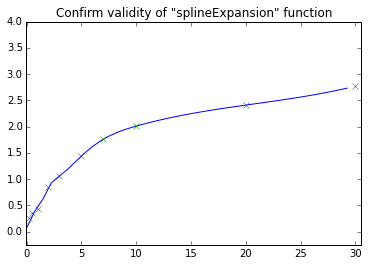

In [34]:
'''
plt.figure()
plt.plot(xnew, diff_s, '-',xnew,y0,'-')
plt.legend(['linear difference'])
plt.axis([-0.05, 30.5, -.25, 0.5]) #a matrix of x, y vectors that frame the graph
plt.title('Difference in maturity (simple difference) on spline - day-over-day')
#ax1.axhline(y=0.000,xmin=0,xmax=3,c="blue",linewidth=0.5,zorder=0)
plt.show()
'''
ynew=tiempo.iloc[262,:]
yaxis=free.iloc[262]
plt.figure()
plt.plot(xnew,ynew,'-',x,yaxis,'x')
plt.axis([-0.05, 30.5, -.25, 4.0])
plt.title('Confirm validity of "splineExpansion" function')
plt.show()

In [35]:
#I think this is working... not yet 100% because the individual spline I'm running is giving me slightly different numbers

print(free.iloc[259])

tck262=sp.splrep(x,free.iloc[262],s=0)

#tck243=sp.splrep(x,day243,s=0)

#the 0th derivative of each...
y262_spl=sp.splev(xnew,tck262,der=0)
'''
print(y262_spl)
print(tiempo.iloc[262,:])
'''

three_month    0.25
six_month      0.43
one            0.55
twoyr          0.90
three          1.14
five           1.52
seven          1.87
ten            2.10
twenty         2.51
thirty         2.90
Name: 2016-01-14 00:00:00, dtype: float64


'\nprint(y262_spl)\nprint(tiempo.iloc[262,:])\n'

At this point I have series/lists of derivatives at each maturity point. From here I can choose to plot point differences between the two series to determine ranges of differences. I can also blow this up and measure linear slopes between maturity groups, ultimately coming back to this study of point differences.

First, to create a dataframe of midpoints of each range of maturity: short, medium, long.

Short term: 2-5 year; medium term: 7-10; long term: 10-30

This won't be as easy as I want because the median of a maturity range may require a linear interpolation between two maturities.

In [36]:
print(tiempo.columns)

st=np.arange(2,5)
med=np.arange(7,10)
lt=np.arange(10,30)

print(np.median(st))
print(np.median(med))
print(np.median(lt))

#tiempo[[1]]

Int64Index([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
            17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
            34, 35, 36, 37, 38, 39],
           dtype='int64')
3.0
8.0
19.5


In [37]:
#print(tiempo.iloc[252,[2]])
#print(tiempo.iloc[252,:])

In [46]:
from scipy import interpolate
#try using scipy.interpolate
xs=[20,19]
#dataframe indexing by column name; in this case, the column name is an integer and not a string
ys=[tiempo[20][252],tiempo[19][252]] #each index returns a bunch of garbage
f=interpolate.interp1d(xs,ys)#create a function out of the interpolation
#print(f(19.5))
'''
print('printing only one: {0}'.format (tiempo.iloc[252,[20]]))
'''

2.434108444


"\nprint('xs are {0}'.format(xs))\n\nprint('ys are {0}'.format(ys))\nprint('printing only one: {0}'.format (tiempo.iloc[252,[20]]))\nprint(tiempo.iloc[252,20])\nprint(tiempo[20][252])\n"

In [58]:
#Verification of the above
xz=[20,19]
yz=[2.450232,2.417985]
f=interpolate.interp1d(xz,yz)

#f(19.5)

Here is a function that accepts one maturit (the median of the maturity range) selects the closest maturity from the interpolated dataframe. The function considers the range of column names of the dataframe parameter to match the median. 

In [ ]:
def calcMedian(x,df):
    down=math.floor(x)
    up=math.ceil(x)
    mats=[df.columns]
    #search for appropriate columns
    #it would be a bit difficult to grab the exact median, so I will just choose the maturity that is closest
    pos=(np.abs(mats-x)).argmin()
    

Now I need to calculate the median rate for the st, mt and lt. I'll put this in a separate dataframe.

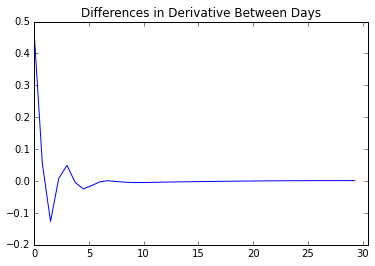

In [21]:
itDiff=y243_spl-y230_spl

plt.plot(xnew, itDiff, '-')
#plt.legend(['ic Spline', 'Derivative'])
plt.axis([-0.05, 30.5, -.2, 0.5]) #a matrix of x, y vectors that frame the graph
plt.title('Differences in Derivative Between Days')
#ax1.axhline(y=0.000,xmin=0,xmax=3,c="blue",linewidth=0.5,zorder=0)
plt.show()


I'll do away with derivatives (limit change of x -> 0) because it doesn't have much practical application. Ex. the derivative at the 10 year maturity between two different dates measures the rate of change of interest rates near the 10 year... but we care about relationships (differences) between a bit wider terms of maturity. The question becomes is measuring point differences (individual maturities) between different maturity groups appropriate?

We observe the slope between 4 sets of maturities to capture steepness for each maturity bucket: short (3mo - 2yr), intermediate.1 (3yr-7yr), intermediate.2 (5yr-10yr), and long (10yr-30yr). The slope can either be measured at the midpoint of the maturity range or the average of the max and min derivative values...

To measure levels, we take the difference in yields (0th derivative) at these same maturities.

We will do this here and place it in the yield dataframe.

In [18]:
#create a function that outputs 4 data points: the derivative value at x = 1.125 yr, 5 yr, 7.5 yr, 20 yr.
sp.splev(1.125, tck, der=1) #verify that a derivative of .29827 is accurate

array(0.2982795394613951)

In [59]:
free.shape

(246, 10)

To compare changes of these measurements over time.

The yield curve (as a whole) can shift in several ways when compared to historical curves:
a) steepen  
b) experience a shift in levels  

'a' requires an analysis on all four maturity buckets and between a couple of maturity differences (2,30) and (10,30) across specific time intervals. We do this by calculating the linear slope between the endpoints of each maturity bucket, as well as the linear slope between the yields of (2,30) and (10,30).
'b' involves calculating the linear difference in yields; calculate average shifts for maturity ranges (short, medium, long)

Write a program that has parameters: length of interval (days), number of intervals. Output Table 1: one table (df or other) with columns = maturities - including the (2,30) and (10,30), rows = linear slope for each maturity... Output Table 2: a similar table as 1 having columns = maturities, rows = average difference in yields for that maturity bucket